In [ ]:
# import tensorflow as tf

# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

In [ ]:
!pip install pytorch-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 176 kB 11.8 MB/s 
     |████████████████████████████████| 1.3 MB 55.1 MB/s 
     |████████████████████████████████| 132 kB 67.2 MB/s 
     |████████████████████████████████| 880 kB 13.7 MB/s 
     |████████████████████████████████| 79 kB 3.9 MB/s 
     |████████████████████████████████| 10.2 MB 28.5 MB/s 
     |████████████████████████████████| 140 kB 26.4 MB/s 
     |████████████████████████████████| 127 kB 49.8 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=8b0a414129f349ecd4d718d0f0864afa70bc724c599140f98a368dd17b638d44
  Stored in directory: /root/.cache/pip/wheels/82/ab/9b/c15899bf659ba74f623ac776e861cf2eb8608c1825ddec66a4
Successfully built sacremoses
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstall

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split

from keras_preprocessing.sequence import pad_sequences
from pytorch_transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification
from pytorch_transformers import AdamW

from tqdm import tqdm, trange
import pandas as pd
import io
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
import pickle
import pandas as pd
from google.colab import drive
# Connect to google drive
drive.mount('/content/gdrive')

# Load data and set labels
#data = pickle.load(open('gdrive/My Drive/Dissertation/formspring_data.pkl', 'rb'))
df = pd.read_csv('gdrive/My Drive/Dissertation/enriched_processed_form+tweet.csv', index_col=0)

Mounted at /content/gdrive


In [ ]:
df.label.value_counts()

1    19553
0    19526
Name: label, dtype: int64

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
No_of_Characters,39079.0,122.354948,76.555517,7.0,64.0,107.0,144.0,910.0
No_of_Words,39079.0,26.075718,16.100767,3.0,14.0,23.0,33.0,99.0
No_of_sentence,39079.0,2.058190,1.268395,1.0,1.0,2.0,3.0,30.0
label,39079.0,0.500345,0.500006,0.0,0.0,1.0,1.0,1.0
sent_length,39079.0,20.579237,13.958837,1.0,10.0,17.0,26.0,93.0


In [ ]:
df = df.dropna(axis=0)

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
No_of_Characters,39079.0,122.354948,76.555517,7.0,64.0,107.0,144.0,910.0
No_of_Words,39079.0,26.075718,16.100767,3.0,14.0,23.0,33.0,99.0
No_of_sentence,39079.0,2.058190,1.268395,1.0,1.0,2.0,3.0,30.0
label,39079.0,0.500345,0.500006,0.0,0.0,1.0,1.0,1.0
sent_length,39079.0,20.579237,13.958837,1.0,10.0,17.0,26.0,93.0


In [ ]:
# from ast import literal_eval
# df['Lemmatized_Text'] = df['Lemmatized_Text'].apply(lambda x: literal_eval(x))
# #Creating a corpus of text feature to encode further into vectorized form
# corpus= []
# for i in df["Lemmatized_Text"]:
#     txt = ' '.join([row for row in i])
#     corpus.append(txt)

In [ ]:
X = df['clean_text']
y = df['label']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=40, stratify=y)

In [ ]:
y_train.value_counts()

1    17598
0    17573
Name: label, dtype: int64

In [ ]:
X_train.values

array(['hey you know that smurfet is the only female smurf do you think shes hoe nah',
       'did even watch the full video the indian man steped right into the crowd the boys didnt do anything except claims harasment after black kid said jesus was black dont say white bois white and friends with tons of colored whatchu got up rn is racism',
       'am down facebok friends since yesterday i have not checked the twitter count that is fine in high schol ached to be the popular girl was very much not was bullied every single day for being unapologeticaly myself just for being me',
       ...,
       'swear some people who support trump are legit brainwashed on the other side no wonder they can convince christian conservatives to kill christians in the middle east fund radical islam they sneak you you eat it up some of you are really that easy to manipulate',
       'honestly think the roles of high school are going to completely change in the future kids will be bullied for being homopho

In [ ]:
sentences = X_train.values
labels = y_train.values

We need to add special tokens ("[SEP]" and "[CLS]") at the beginning and end of each sentence for XLNet to work properly.

For BERT, the special token pattern looks like this:

[CLS] + Sentence_A + [SEP] + Sentence_B + [SEP]

Whereas with XLNet the token pattern looks like this:

Sentence_A + [SEP] + Sentence_B + [SEP] + [CLS]

For single sentence inputs here, we just need to add [SEP] and [CLS] to the end:

In [ ]:
sentences = [sentence + " [SEP] [CLS]" for sentence in sentences]

In [ ]:
sentences[0]

'hey you know that smurfet is the only female smurf do you think shes hoe nah [SEP] [CLS]'

Next, import the XLNet tokenizer, used to convert our text into tokens that correspond to XLNet's vocabulary.

In [ ]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['▁he', 'y', '▁you', '▁know', '▁that', '▁', 's', 'mur', 'fe', 't', '▁is', '▁the', '▁only', '▁female', '▁', 's', 'mur', 'f', '▁do', '▁you', '▁think', '▁she', 's', '▁', 'hoe', '▁', 'nah', '▁[', 's', 'ep', ']', '▁[', 'cl', 's', ']']


XLNet requires specifically formatted inputs. For each tokenized input sentence, we need to create:

input ids: a sequence of integers identifying each input token to its index number in the XLNet tokenizer vocabulary
segment mask: (optional) a sequence of 1s and 0s used to identify whether the input is one sentence or two sentences long. For one sentence inputs, this is simply a sequence of 0s. For two sentence inputs, there is a 0 for each token of the first sentence, followed by a 1 for each token of the second sentence
attention mask: (optional) a sequence of 1s and 0s, with 1s for all input tokens and 0s for all padding tokens (we'll detail this in the next paragraph)
labels: a single value of 1 or 0. In our task 1 means "grammatical" and 0 means "ungrammatical"

In [ ]:
# Set the maximum sequence length. We'll leave room on the end anyway. 
MAX_LEN = 160

In [ ]:
# Use the XLNet tokenizer to convert the tokens to their index numbers in the XLNet vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [ ]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

Create the attention masks 

In [ ]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [ ]:
# Use train_test_split to split our data into train and validation sets for training

# train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.1)
# train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=2018, test_size=0.1)

train_inputs = input_ids
train_labels = labels
train_masks = attention_masks

In [ ]:
print(len(input_ids))
y_train.value_counts()

35171


1    17598
0    17573
Name: label, dtype: int64

In [ ]:
print(len(attention_masks))

35171


In [ ]:
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

In [ ]:
# Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
# validation_sampler = SequentialSampler(validation_data)
# validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


# Train model

Now that our input data is properly formatted, it's time to fine tune the XLNet model.

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 12.4 MB/s 
     |████████████████████████████████| 182 kB 75.4 MB/s 
     |████████████████████████████████| 7.6 MB 63.0 MB/s 


In [ ]:
from transformers import XLNetForSequenceClassification

In [ ]:
# Load XLNEtForSequenceClassification, the pretrained XLNet model with a single linear classification layer on top. 

model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2)

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [ ]:
model.cuda()

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [ ]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters,
                     lr=2e-5)

At each pass we need to:

Training loop:

Tell the model to compute gradients by setting the model in train mode
Unpack our data inputs and labels
Load data onto the GPU for acceleration
Clear out the gradients calculated in the previous pass. In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out
Forward pass (feed input data through the network)
Backward pass (backpropagation)
Tell the network to update parameters with optimizer.step()
Track variables for monitoring progress
Evalution loop:

Tell the model not to compute gradients by setting th emodel in evaluation mode
Unpack our data inputs and labels
Load data onto the GPU for acceleration
Forward pass (feed input data through the network)
Compute loss on our validation data and track variables for monitoring progress

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import gc
gc.collect()

0

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    logits = outputs[1]
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # # Validation

  # # Put model in evaluation mode to evaluate loss on the validation set
  # model.eval()
 
  # # Tracking variables 
  # eval_loss, eval_accuracy = 0, 0
  # nb_eval_steps, nb_eval_examples = 0, 0

  # # Evaluate data for one epoch
  # for batch in validation_dataloader:
  #   # Add batch to GPU
  #   batch = tuple(t.to(device) for t in batch)
  #   # Unpack the inputs from our dataloader
  #   b_input_ids, b_input_mask, b_labels = batch
  #   # Telling the model not to compute or store gradients, saving memory and speeding up validation
  #   with torch.no_grad():
  #     # Forward pass, calculate logit predictions
  #     output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
  #     logits = output[0]
    
  #   # Move logits and labels to CPU
  #   logits = logits.detach().cpu().numpy()
  #   label_ids = b_labels.to('cpu').numpy()

  #   tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
  #   eval_accuracy += tmp_eval_accuracy
  #   nb_eval_steps += 1

  # print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/pytorch_transformers/optimization.py:166: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1420.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)
Epoch:  25%|██▌       | 1/4 [20:51<1:02:34, 1251.40s/it]

Train loss: 0.345500571124933


Epoch:  50%|█████     | 2/4 [41:44<41:44, 1252.21s/it]  

Train loss: 0.27228616918352516


Epoch:  75%|███████▌  | 3/4 [1:02:37<20:52, 1252.58s/it]

Train loss: 0.23226896234534003


Epoch: 100%|██████████| 4/4 [1:23:31<00:00, 1252.80s/it]

Train loss: 0.19580966867083174


In [ ]:
torch.save(model, "gdrive/My Drive/Dissertation/enriched_form+tweet_xlnetmodel")

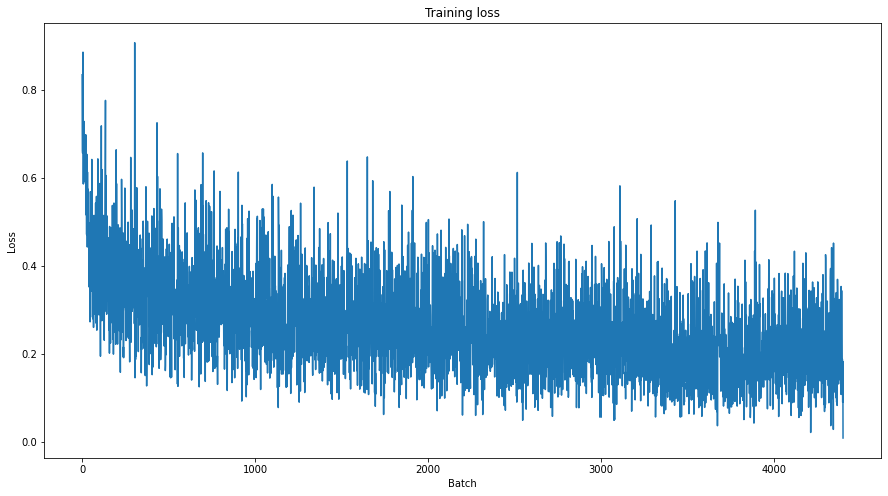

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

# Prediction on test set

In [ ]:
t_sentences = X_test.values
t_labels = y_test.values

In [ ]:
t_sentences = [sentence + " [SEP] [CLS]" for sentence in t_sentences]


In [ ]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)
t_tokenized_texts = [tokenizer.tokenize(sent) for sent in t_sentences]

# Set the maximum sequence length.
MAX_LEN = 160

# Use the XLNet tokenizer to convert the tokens to their index numbers in the XLNet vocabulary
t_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in t_tokenized_texts]
# Pad our input tokens
t_input_ids = pad_sequences(t_input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
t_attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in t_input_ids:
  seq_mask = [float(i>0) for i in seq]
  t_attention_masks.append(seq_mask)

In [ ]:
test_inputs = torch.tensor(t_input_ids)
test_labels = torch.tensor(t_labels)
test_masks = torch.tensor(t_attention_masks)

In [ ]:
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
model = torch.load("gdrive/My Drive/Dissertation/enriched_form+tweet_xlnetmodel")

In [ ]:
# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [ ]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

In [ ]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

In [ ]:
matthews_set

[0.6888467201936644,
 0.9379228369755696,
 0.875,
 0.6888467201936644,
 0.6454972243679028,
 0.6735808793898638,
 0.598254541756288,
 0.938872452190116,
 0.5530100413375021,
 0.8140915784106943,
 0.8783100656536799,
 0.7562449037944323,
 0.7984472665856134,
 0.8749672939989046,
 0.7745966692414834,
 0.47306844125299624,
 0.8805899139163632,
 0.8206518066482898,
 0.7769911005144381,
 0.24305875451990117,
 0.7559289460184544,
 0.8704453441295547,
 1.0,
 0.6625413488689132,
 0.6735808793898638,
 0.8563488385776753,
 0.5269860393922079,
 0.8126375006351424,
 0.5163977794943222,
 0.6494848686351458,
 0.7481900559272088,
 0.7408906882591093,
 0.7568627450980392,
 0.7559289460184544,
 0.6,
 1.0,
 0.8819171036881969,
 0.6952687917708212,
 0.746031746031746,
 0.611336032388664,
 0.8745098039215686,
 0.938872452190116,
 0.8140915784106943,
 0.6625413488689132,
 0.6813969328454993,
 0.6735808793898638,
 0.6235294117647059,
 0.4879500364742666,
 0.7984472665856134,
 0.7408906882591093,
 0.62352941

In [ ]:
matthews_corrcoef(flat_true_labels, flat_predictions)

0.7198821567081928

Accuracy: 85.95%
F1 score: 86.29%
Precision: 84.29%
Recall: 88.39%
Accuracy 0.86


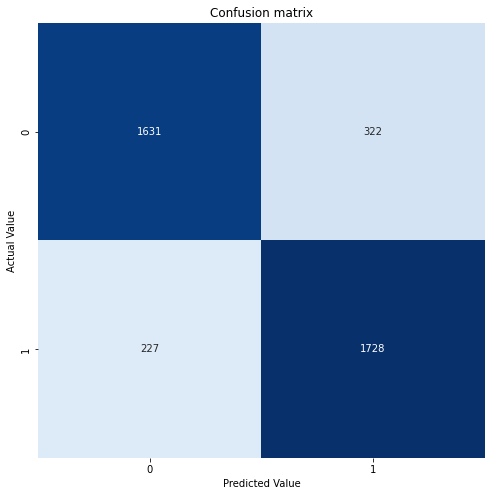

              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1953
           1       0.84      0.88      0.86      1955

    accuracy                           0.86      3908
   macro avg       0.86      0.86      0.86      3908
weighted avg       0.86      0.86      0.86      3908



In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

accuracy = accuracy_score(flat_true_labels, flat_predictions)
print(f'Accuracy: {accuracy*100:.2f}%')
f1 = f1_score(flat_true_labels, flat_predictions)
print(f'F1 score: {f1*100:.2f}%')
precision = precision_score(flat_true_labels, flat_predictions)
print(f'Precision: {precision*100:.2f}%')
recall = recall_score(flat_true_labels, flat_predictions)
print(f'Recall: {recall*100:.2f}%')

c_matrix =confusion_matrix(flat_true_labels,flat_predictions)
clr = classification_report(flat_true_labels,flat_predictions)
accuracy = accuracy_score(flat_true_labels, flat_predictions)
print("Accuracy", round(accuracy,2) )
plt.figure(figsize=(8,8))
sns.heatmap(c_matrix,annot=True, fmt='g', vmin=0, cbar=False, cmap='Blues')
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.title("Confusion matrix")
plt.show()
print(clr)

AUC: 0.8595


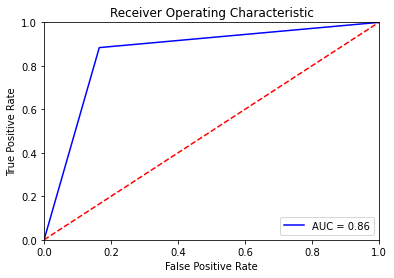

In [ ]:
fpr, tpr, threshold = roc_curve(flat_true_labels,flat_predictions)
roc_auc = auc(fpr, tpr)
print(f'AUC: {roc_auc:.4f}')

# Plot ROC AUC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()